<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving content_lab5.jpg to content_lab5.jpg

Upload Style Image


Saving style_lab5.jpg to style_lab5.jpg
Content Path: <_io.BytesIO object at 0x7f2dbcf33230>
Style Path: <_io.BytesIO object at 0x7f2c9944ead0>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


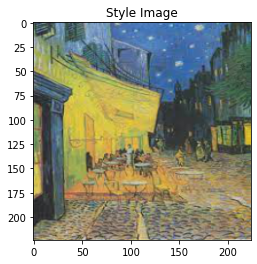

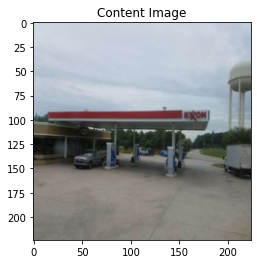

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2",
             "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3",
             "maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer.
ccl1 = vgg_names.index('conv1_2')
chosen_content_layer = [ccl1]
csl1, csl2, csl3, csl4 = vgg_names.index('conv2_1'), vgg_names.index('conv2_2'), vgg_names.index('conv3_1'), vgg_names.index('conv3_2')
chosen_style_layer = [csl1, csl2, csl3, csl4]

# Initialize our models (only once to hopefully avoid the problem of computing backprop twice).
content_model = VGGIntermediate(requested=chosen_content_layer).cuda()
style_model = VGGIntermediate(requested=chosen_style_layer).cuda()

# This returns dictionaries {layer number (corresponding with the index I wanted): weights associated (after putting my image in)}
content_layers = content_model(content_image)
style_layers = style_model(style_image)

# This gets only the weights associated in a list that correspond with the images I want to mess with.
content_layers = [content_layers[i] for i in content_layers]
#[content_layers.values()]
style_layers = [style_layers[i] for i in style_layers]
#[style_layers.values()]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [ ]:
# https://towardsdatascience.com/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916
# https://www.youtube.com/watch?v=Elxnzxk-AUk
  # Gram matrix is simply the dot product of the given matrix to show what they style of the image is.
def gram_matrix(input):
   b, c, h, w = input.size()  # batch, channel, height, width.
   x = input.view(b*c, h*w)
   gram = torch.mm(x, x.t())
   return gram.div(b*c*h*w)

# Computes the MSELoss between the content image (the image I put in) and the generated image (the one my model is generating).  
class ContentLoss(nn.Module):
  def __init__(self, cont_image):
    super(ContentLoss, self).__init__()
    self.targ_image = cont_image.clone().detach()  # <- Detach is important so this variable does
                                                    # not contain any of the prior information
                                                    # from the pre-trained network.
  def forward(self, input_image):  
    return F.mse_loss(input_image, self.targ_image)# This computes the MSE of our generated image 
                                                    # vs. our content image.

# Computes the MSELoss between the gram-applied style image (the image I want the style of applied to the content image),
  # and the generated image (the image that represents the blend between the content and style images).
class StyleLoss(nn.Module):
  def __init__(self, style_image):
    super(StyleLoss, self).__init__()
    self.gram_style = gram_matrix(style_image.clone().detach())  # <- Detach argument, same as above.
  
  def forward(self, input_img): 
    gram = gram_matrix(input_img)                   # Get the gram_matrix values of the current generated
                                                      # image we are working with.
    return F.mse_loss(gram, self.gram_style)        # This computes the MSE of our gram style image
                                                     # vs. our gram generated image.


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



In [ ]:
print(layers.keys())
print(chosen_style_layer[1])
print(chosen_content_layer)

dict_keys([0, 2, 5, 10, 17, 24])


5

In [ ]:
content_losses = [ContentLoss(l) for l in content_layers]
style_losses

[StyleLoss(), StyleLoss(), StyleLoss(), StyleLoss()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch: 0, content_loss: 0.0, style_loss: 3132.106689453125
Epoch: 50, content_loss: 44.83517074584961, style_loss: 66.35818481445312
Epoch: 100, content_loss: 36.50342559814453, style_loss: 12.045312881469727
Epoch: 150, content_loss: 32.00004196166992, style_loss: 7.700181484222412
Epoch: 200, content_loss: 28.485923767089844, style_loss: 6.427218437194824
Epoch: 250, content_loss: 26.177461624145508, style_loss: 12.866883277893066
Epoch: 300, content_loss: 28.59465789794922, style_loss: 48.47163009643555
Epoch: 350, content_loss: 35.4743766784668, style_loss: 115.7029037475586
Epoch: 400, content_loss: 30.536785125732422, style_loss: 30.70556640625
Epoch: 450, content_loss: 27.774723052978516, style_loss: 34.31956481933594


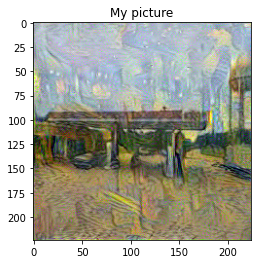

In [ ]:
# Start with a copy of the content image
copy_content_image = content_image.clone().requires_grad_(True)

num_epochs = 500
alpha = 10
beta = 250000

optimizer = optim.Adam([copy_content_image], lr=0.1)
model = VGGIntermediate(requested=chosen_content_layer + chosen_style_layer).cuda()

content_losses = [ContentLoss(l) for l in content_layers]  # This creates a ContentLoss function for each layer.
                                                           # (I only use one layer, so there is only one function in this list.)
style_losses = [StyleLoss(l) for l in style_layers]        # This creates a StyleLoss function for each layer.
                                                           # (I use four layers, so there are four functions in this list.)

for epoch in range(num_epochs):
  optimizer.zero_grad()

  my_model = model(copy_content_image)
  total_content_loss = 0
  total_style_loss = 0

  # These next few lines are pretty complicated, so I am going to dedicate a few lines explaining them.
  # The first for loop
    # Remember that content_losses is a list of functions. So, need to index the list which is why we have 'content_losses[i].'
    # Since content_losses[i] is a function, we need to pass in something for that function to do. 'my_model' is the model, so we need to
    # pass something into that. We want to pass the selected pre-trained layers from vgg into the model so we can get the alterations to our
    # picture. So, my_model[chosen_content_layer[i]] gives us the new weights and whatnot for the content image and the pre-trained layers.
    # Passing my_model[chosen_content_layer[i]] into content_losses[i] will send the new weights from my_model[chosen_content_layer[i]] to
    # the ContentLoss function. This will compute the MSE between the original content image, and the new content image that has the
    # pre-trained layers applied to it. We then add this value (the MSE) to total_content_loss so we can get the total content loss across
    # all layers. Since I only use one content layer, this only happens one time.
  # The second for loop
    # This is loop is the exact same as the previous for loop, just with the style layers and image instead of content layers and image.

  for i in range(len(content_losses)):
    total_content_loss += content_losses[i](my_model[chosen_content_layer[i]])
  for i in range(len(style_losses)):
    total_style_loss += style_losses[i](my_model[chosen_style_layer[i]])
  
  total_content_loss *= alpha
  total_style_loss   *= beta

  total_loss = total_content_loss + total_style_loss
  total_loss.backward()
  optimizer.step()

  if epoch % 50 == 0:
    print(f"Epoch: {epoch}, content_loss: {total_content_loss}, style_loss: {total_style_loss}")

  
display(torch.clamp(copy_content_image, min=0, max=1), title="My picture")



### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

- Equation 1: $L_{content}(\overrightarrow{p}, \overrightarrow{x},l) = \frac{1}{2} \sum_{i,j}(F_{ij}^{l}-P_{ij}^{l})^2$

$L_{content}(\overrightarrow{p}, \overrightarrow{x},l)$: This is the equation for content loss, where $\overrightarrow{p}$ is the image that we are using as content, $\overrightarrow{x}$ is is the created image, and $\overrightarrow{l}$ is the layer that we are computing the loss for. This is also the L2 norm.

$F_{ij}^{l}$: When all of the layers $l$ are passed through the pre-trained VGG network, $F_{ij}^{l}$ becomes a list of all the activation maps for the **generated image**. For this variable, $i$ represents the numbers of filters from layer $l$ on pixel $j$.

$P_{ij}^{l}$: When all of the layers $l$ are passed through the pre-trained VGG network, $P_{ij}^{l}$ becomes a list of all the activation maps for the **content image**. The $ij$ and $l$ are the same as above.  


- Equation 3: $G_{ij}^{l} = \sum_{k}F_{ik}^{l}F_{jk}^{l}$

$G_{ij}^{l}$: This is the gram matrix. The gram matrix is the inner product on layer $l$ between the feature maps $i$ and $j$ (in vector form). $F_{ij}$ and $F_{jk}$ are parallel to $F_{ij}$ from the above equation. The gram matrix tells us how similar all of the activation maps are. The easiest way to calculate the gram matrix is $FF^{T}$.


- Equation 4: $E_{l} = \frac{1}{4N_{l}^{2}M_{l}^{2}} \sum_{i,j}(G_{ij}^{l}-A_{ij}^{l})^{2}$

$E_{l}$: This is the contribution to the total loss from a single layer $l$.

$N_{l}$: For each layer $l$, $N_{l}$ is the number of channels for each feature map in that layer.

$M_{l}$: For each later $l$, $M_{l}$ is the $ height*width $ for each feature map in that layer. 

$G_{ij}^{l}$: This is the gram matrix for each layer $l$ of the **generated image** (see equation 3).

$A_{ij}^{l}$: This is the gram matrix for each layer $l$ of the **style image** (see equation 3). Another thing to consider is that this only needs to be calculated once since the style image does not change.

- Equation 5: $L_{style}(\overrightarrow{a}, \overrightarrow{x}) = \sum_{l=0}^{L}w_{l}E_{l}$

$L_{style}(\overrightarrow{a},\overrightarrow{x})$: Very similar to equation 1, this equation computes the loss of the style between the style image $\overrightarrow{a}$ and the generated image $\overrightarrow{x}$.

$w_{l}$: This represents the weight factor of contribution of each layer.

$E_{l}$: This is the value from equation 4. 